In [1]:
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

Title of Project: Did Steve Nash really deserve his MVPs?

Hypotehsis: Steve Nash's assists, pts and minutes are correlated to the Suns games. Thus can we use these variables to retroactively predict the Suns' post season and how accurate is it?

Link: https://www.landofbasketball.com/nba_players_game_logs/2005/steve_nash.htm

I actually know how to extract data from html better this time thus I can now get and access better data, but also getting table from raw html means a lot of the data will be bad or misformatted

In [2]:
def WL(x):
    if x.__contains__('W'):
        return 1
    else:
        return 0

In [3]:
data = pd.read_csv("nash_05.csv", index_col=False)
data['WL']=data['WL'].map(lambda x: WL(x))
data.drop(['Unnamed: 18'],axis=1, inplace=True)
pts_ = data['Score'].copy()
for i in range(pts_.size):
    if pts_[i].__contains__("OT"):
        pts_[i]=pts_[i].replace("OT", '')
    pts_[i] = pts_[i].split("-")
    pts_[i] = int(pts_[i][0])-int(pts_[i][1])

pts = pd.Series(pts_)
data['pts_dif'] = pts
reg = data.iloc[:76]
post = data.iloc[76:]
reg

/tmp/ipykernel_6346/2608845753.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv("nash_05.csv", index_col=False)


,Gm,Date,Opponent,WL,Score,Min,Pts,ORb,DRb,Reb,Ast,Stl,Blk,TO,PF,FGM/A,3PM/A,FTM/A,pts_dif
0,1,Nov. 03,vs. Hawks,1,112 - 82,24,12,0,3,3,4,2,0,3,2,6,-,12,30
1,2,Nov. 05,@ 76ers,1,108 - 98,32,9,0,4,4,10,0,0,4,5,3,-,5,10
2,3,Nov. 06,@ Nets,1,112 - 80,37,17,1,1,2,8,3,0,6,0,6,-,8,32
3,4,Nov. 09,@ Bulls,1,94 - 74,33,8,0,3,3,12,0,0,1,3,3,-,9,20
4,5,Nov. 10,@ Cavaliers,0,109 - 114OT,50,15,1,6,7,17,0,0,1,5,5,-,13,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,Apr. 12,vs. Hornets,1,99 - 85,35,6,2,1,3,13,1,0,2,1,3,-,11,14
72,73,Apr. 15,vs. Clippers,1,98 - 91,41,14,2,1,3,11,1,0,4,2,6,-,17,7
73,74,Apr. 16,vs. Kings,1,116 - 98,26,4,0,6,6,11,0,0,3,2,2,-,3,18
74,75,Apr. 18,vs. Nuggets,1,128 - 114,26,8,0,0,0,13,2,0,4,1,2,-,2,14


In [28]:
post

,Gm,Date,Opponent,WL,Score,Min,Pts,ORb,DRb,Reb,Ast,Stl,Blk,TO,PF,FGM/A,3PM/A,FTM/A,pts_dif
76,77,Apr. 27,vs. Grizzlies,1,108 - 103,40,12,1,1,2,15,1,0,4,3,5,-,16,5
77,78,Apr. 29,@ Grizzlies,1,110 - 90,36,13,0,3,3,8,1,0,2,3,6,-,9,20
78,79,May. 01,@ Grizzlies,1,123 - 115,38,24,1,3,4,9,0,0,7,1,6,-,10,8
79,80,May. 09,vs. Mavericks,1,127 - 102,31,11,1,5,6,13,0,0,4,4,4,-,10,25
80,81,May. 11,vs. Mavericks,0,106 - 108,42,23,0,3,3,13,0,0,3,2,9,-,22,-2
81,82,May. 13,@ Mavericks,1,119 - 102,42,27,0,3,3,17,2,0,7,1,12,-,21,17
82,83,May. 15,@ Mavericks,0,109 - 119,43,48,1,4,5,5,3,1,9,4,20,-,28,-10
83,84,May. 18,vs. Mavericks,1,114 - 108,42,34,0,13,13,12,1,0,5,0,13,-,26,6
84,85,May. 20,@ Mavericks,1,130 - 126OT,50,39,5,4,9,12,0,1,4,5,14,-,24,4
85,86,May. 22,vs. Spurs,0,114 - 121,41,29,0,4,4,13,1,1,6,5,12,-,22,-7


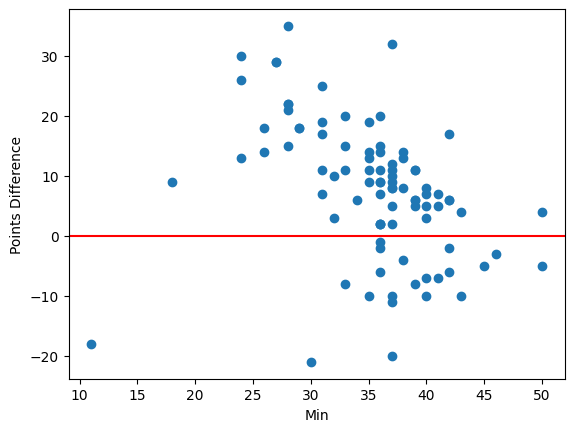

In [4]:
features=['Min', 'Pts', 'Ast']
plt.plot(data['Min'], data['pts_dif'], 'o')
plt.xlabel("Min")
plt.ylabel("Points Difference")
plt.axhline(y = 0, color = 'r', linestyle = '-') 

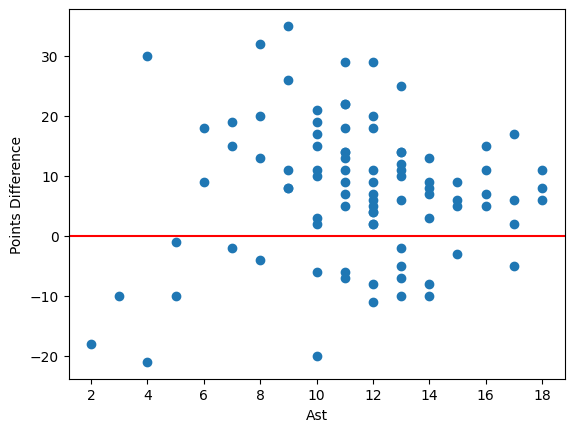

In [5]:
plt.plot(data['Ast'], data['pts_dif'], 'o')
plt.xlabel("Ast")
plt.ylabel("Points Difference")
plt.axhline(y = 0, color = 'r', linestyle = '-') 

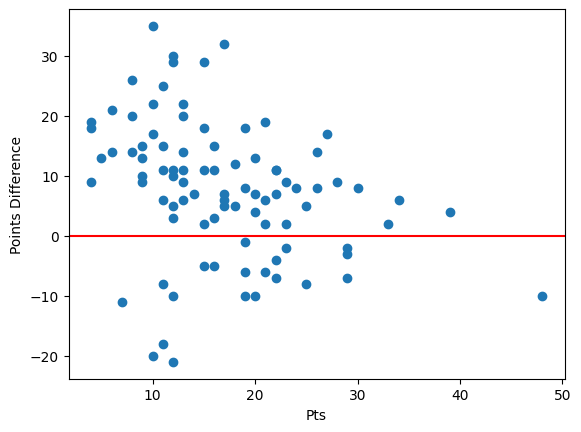

In [6]:
plt.plot(data['Pts'], data['pts_dif'], 'o')
plt.xlabel("Pts")
plt.ylabel("Points Difference")
plt.axhline(y = 0, color = 'r', linestyle = '-') 

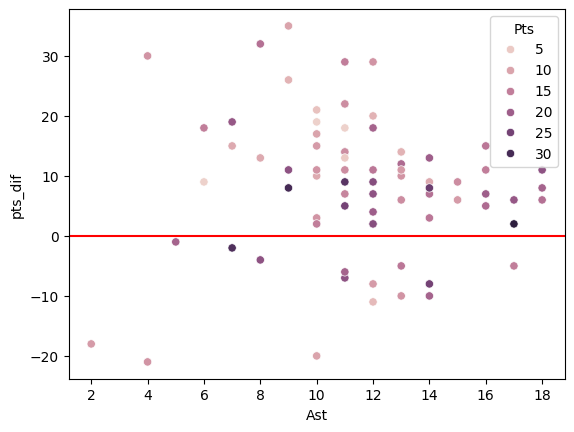

In [8]:
_ = sns.scatterplot(x='Ast', y='pts_dif', hue='Pts', data=reg)
plt.axhline(y = 0, color = 'r', linestyle = '-') 

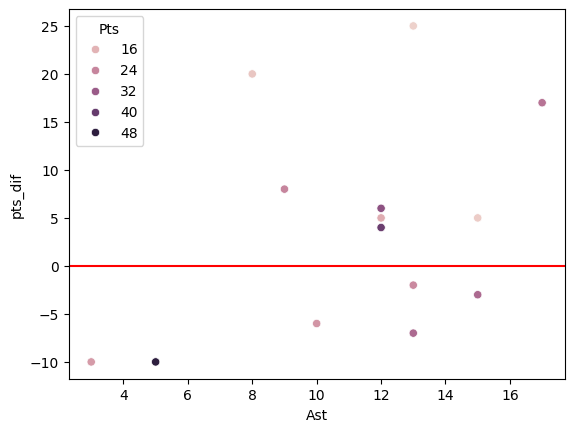

In [29]:
_ = sns.scatterplot(x='Ast', y='pts_dif', hue='Pts', data=post)
plt.axhline(y = 0, color = 'r', linestyle = '-') 

[Text(0.6, 0.9166666666666666, 'Min <= 44.0\ngini = 0.317\nsamples = 76\nvalue = [15.0, 61.0]'),
 Text(0.5, 0.75, 'Ast <= 5.5\ngini = 0.29\nsamples = 74\nvalue = [13, 61]'),
 Text(0.55, 0.8333333333333333, 'True  '),
 Text(0.3, 0.5833333333333334, 'Min <= 27.0\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(0.2, 0.4166666666666667, 'Min <= 17.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.1, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.3, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.4, 0.4166666666666667, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.7, 0.5833333333333334, 'Min <= 32.5\ngini = 0.245\nsamples = 70\nvalue = [10, 60]'),
 Text(0.6, 0.4166666666666667, 'gini = 0.0\nsamples = 20\nvalue = [0, 20]'),
 Text(0.8, 0.4166666666666667, 'Ast <= 14.5\ngini = 0.32\nsamples = 50\nvalue = [10, 40]'),
 Text(0.7, 0.25, 'Pts <= 18.5\ngini = 0.381\nsamples = 39\nvalue = [10, 29]'),
 Text(0.6, 0.08333333333333333, 'gini = 0.298\nsamples = 22\nvalue 

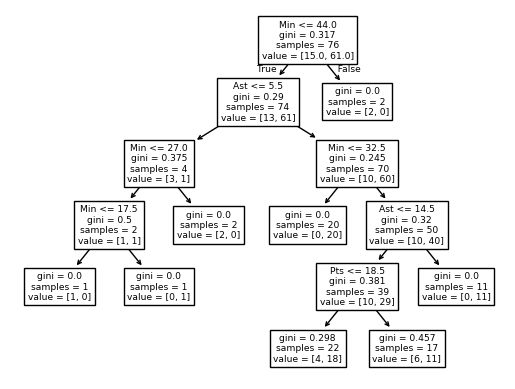

In [9]:
X = reg[features]
y = reg['WL']
dtree = DecisionTreeClassifier(max_depth=5)
dtree = dtree.fit(X, y)

tree.plot_tree(dtree, feature_names=features)

model score: 0.782608695652174


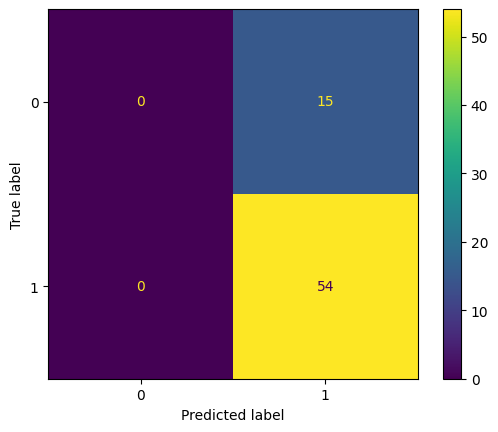

In [16]:
def test_train_opt_sp():
    score = {}
    mx = 0
    i = 0.1
    while i <= 0.9:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
        dt_model = DecisionTreeClassifier().fit(X_train, y_train)
        score[dt_model.score(X_test, y_test)] = i
        i+=0.1
    for k in score.keys():
        if k > mx:
            mx = k
    return score[mx], mx

t = test_train_opt_sp()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t[0], random_state=42)
dt_model = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
print("model score:", t[1])
cm = confusion_matrix(y_test, dt_model.predict(X_test))  #.ravel()
_ = ConfusionMatrixDisplay(cm).plot() #the score is no good

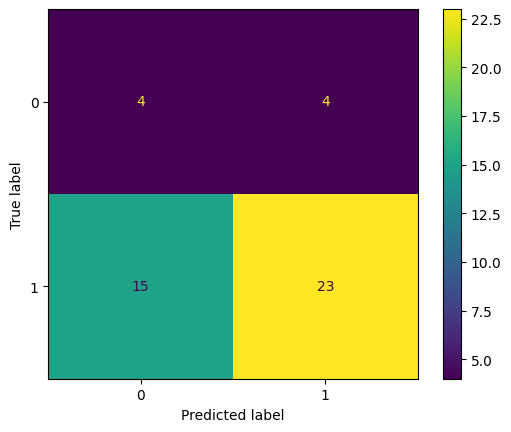

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)
dt_model = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
dt_model = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
cm = confusion_matrix(y_test, dt_model.predict(X_test))  #.ravel()
_ = ConfusionMatrixDisplay(cm).plot()

In [26]:
true_res = post['WL']
def f1(true, pred):
    count = 0
    for i in range(len(true)):
        if pred[i] == 1 and pred[i] == true[i]:
            count+=1
    return (2*count)/(2*len(true))

In [27]:
pred = dt_model.predict(post[features])

accuracy_score(true_res, pred)

0.5714285714285714

Well the accuracy score is basically a toincoss which is no good, the data also predicted that Steve Nash will win all post season games, which did not happen. This is most likely due to the fact that he plays well in the post season just his team did not win. The best we can conclude from this is he played well and a lot (which is what teams ususally do) no matter what so bare mnimum is he is a great player, we just cannot predict wins and losses from one single player playing and not when that player plays well no matter what.